# SP dataset

PyCMTensor ResLogit Model


We import the dataset into the `cmt.Database()` class and indicate the choice column in the argument `choiceVar`.

In [1]:
import os
import pandas as pd
import pycmtensor as cmt
cmt.__version__
cmt.logger.set_level(cmt.logger.ERROR)

# read csv file and set columns to UPPERCASE
nb_path = os.path.abspath("")
model_average_sp = pd.read_csv("data/model_average_SP.csv")
model_average_sp.columns = model_average_sp.columns.str.upper()

# load database
db = cmt.Database("model_average_sp", model_average_sp, choiceVar="CHOICE")
globals().update(db.variables)

## Data preparation
We perform some data cleaning and setting the choices to start from index 0.

In [2]:
# additional steps to format database
db.data["CHOICE"] -= 1
c = db.data.loc[:, "TT1":"HH_INC_ABS"].columns.to_list()
db.autoscale(variables=c, verbose=False)

## Model specification
from the `pycmtensor` library, we import two classes to help us define the betas and (neural network) weights.

In [3]:
from pycmtensor.expressions import Beta, Weights

# specify Beta parameters
b_cost = Beta("b_cost", 0.0, None, None, 0)
b_time = Beta("b_time", 0.0, None, None, 0)
b_hw = Beta("b_hw", 0.0, None, None, 0)
b_ch = Beta("b_ch", 0.0, None, None, 0)
b_hh_inc1 = Beta("b_hh_inc1", 0.0, None, None, 1)  # do not estimate
b_hh_inc2 = Beta("b_hh_inc2", 0.0, None, None, 0)
b_carav1 = Beta("b_carav1", 0.0, None, None, 0)
b_carav2 = Beta("b_carav2", 0.0, None, None, 1)  # do not estimate
b_com = Beta("b_com", 0.0, None, None, 0)
b_shop = Beta("b_shop", 0.0, None, None, 0)
b_bis = Beta("b_bis", 0.0, None, None, 0)
b_lei = Beta("b_lei", 0.0, None, None, 0)
asc_alt1 = Beta("asc_alt1", 0.0, None, None, 0)
asc_alt2 = Beta("asc_alt2", 0.0, None, None, 1)  # do not estimate

# specify weight parameters
W1 = Weights("ResNet_01a", (2, 16), 0, True)
W2 = Weights("ResNet_01b", (16, 2), 0, True)

We specify the utility functions for the two choices respectively as `U_1` and `U_2`.

In [4]:

U_1 = (
    b_cost * db["TC1"]
    + b_time * db["TT1"]
    + b_hw * db["HW1"]
    + b_ch * db["CH1"]
    + b_hh_inc1 * db["HH_INC_ABS"]
    + b_carav1 * db["CAR_AVAILABILITY"]
    + b_com * db["COMMUTE"]
    + b_bis * db["BUSINESS"]
    + asc_alt1
)
U_2 = (
    b_cost * db["TC2"]
    + b_time * db["TT2"]
    + b_hw * db["HW2"]
    + b_ch * db["CH2"]
    + b_hh_inc2 * db["HH_INC_ABS"]
    + b_shop * db["SHOPPING"]
    + b_lei * db["LEISURE"]
    + b_carav2 * db["CAR_AVAILABILITY"]
    + asc_alt2
)

# Associate utility functions with the list
U = [U_1, U_2]

Here, we apply the ResLogit structure to our utility functions. `W1` and `W2` are the input and output weights of the residual layers.

In [5]:
from pycmtensor.models import ResLogitLayer

# generate the output from the ResLogit Layer
U = ResLogitLayer(U, W1, W2).output

## Estimation
The main estimation algorithm is as follows. We apply the Adam optimization algorithm and use a batch size of 128 samples. A cyclic learning rate is applied to the training process.

In [6]:
import dill as pickle
from pycmtensor.models import MNLogit
from pycmtensor.optimizers import Adam

model = MNLogit(u=U, av=None, database=db, name="sp_model")
model.add_params(locals())
model.config["patience"] = 20000
model.config["max_epoch"] = 1000
model.config["batch_size"] = 128
model.config["base_lr"] = 0.005
model.config["max_lr"] = 0.01
model.config["learning_scheduler"] = "CyclicLR"
model.config["cyclic_lr_step_size"] = 8

# train function
model = cmt.train(model, database=db, optimizer=Adam, notebook=True,)

dataset: model_average_sp (n=2790)
batch size: 128
iterations per epoch: 21


Loglikelihood:  -1954.341  Score: 0.498

Epoch    0/21000:   0%|          | 0.00/21.0k [00:00<?, ?it/s]

Optimization complete with accuracy of 79.677%. Max loglikelihood reached @ epoch 936.



## Results
The results of the model are printed by calling the `Results` class on the estimated model.

In [7]:
from pycmtensor.results import Results

result = Results(model, db)
result.print_beta_statistics()
result.print_correlation_matrix()

Results for model: sp_model
Build time: 00:00:24
Estimation time: 00:00:50
Estimation rate: 400.208 iter/s
Seed value: 700
Number of Beta parameters: 11
Tensor size: 64
Sample size: 2790
Excluded data: 0
Init loglikelihood: -1954.341
Final loglikelihood: -1281.787
Final loglikelihood reached at: epoch 936
Likelihood ratio test: 1345.107
Accuracy: 79.677%
Rho square: 0.344
Rho bar square: 0.306
Akaike Information Criterion: 2713.57
Bayesian Information Criterion: 3158.61
Final gradient norm: 0.094

Statistical Analysis:
              Value   Std err     t-test   p-value Rob. Std err Rob. t-test Rob. p-value
asc_alt1   0.223716  0.768463   0.291121  0.770959     0.735876    0.304013     0.761118
b_bis     -0.246334  0.784045  -0.314183  0.753382     0.824733   -0.298683     0.765182
b_carav1  -0.095026  0.046931  -2.024787  0.042889     0.018972   -5.008623     0.000001
b_ch       -0.62469  0.050496 -12.371011       0.0     0.071133    -8.78194          0.0
b_com     -0.118236  0.773463 

Optionally, we can plot the estimation performance vs. the number of iterations. Note that the x-axis is on a log-scale.

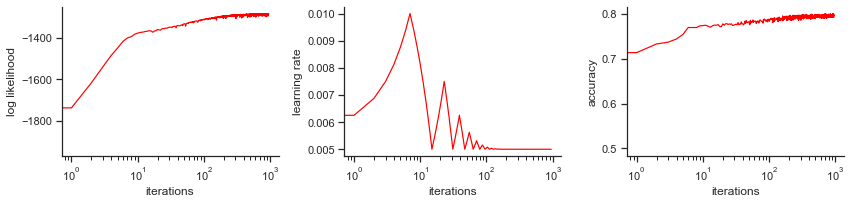

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 1.2})
log = model.tracker.get_data()
fig, axs = plt.subplots(1, 3, figsize=(12, 3), squeeze=False)
g1 = sns.lineplot(ax=axs[0, 0], data=log, x=log.index, y="full_ll", color="red")
g2 = sns.lineplot(ax=axs[0, 1], data=log, x=log.index, y="lr", color="red")
g3 = sns.lineplot(
    ax=axs[0, 2], data=log, x=log.index, y="score", color="red"
)  # y = score or full_ll or lr
g1.set(xscale="log", xlabel="iterations", ylabel="log likelihood")
g2.set(xscale="log", xlabel="iterations", ylabel="learning rate")
g3.set(xscale="log", xlabel="iterations", ylabel="accuracy")
sns.despine()
plt.tight_layout()
plt.show()


## Output choice probabilities
To generate the probability outputs, we call the `Predict` class on the model `model` and the database `db`. Two methods are used: `probs()` to generate the probabilities and `choices()` to generate a pseudo-choice output by selecting the choice with the highest probability. The code below concatenates the probabilities and choices together.

In [9]:
from pycmtensor.results import Predict

pd.concat((Predict(model, db).probs(), Predict(model, db).choices()), axis=1)

,0,1,CHOICE
0,0.207365,0.792635,1
1,0.113172,0.886828,1
2,0.898947,0.101053,0
3,0.199755,0.800245,1
4,0.065866,0.934134,1
...,...,...,...
2785,0.663225,0.336775,0
2786,0.139354,0.860646,1
2787,0.583219,0.416781,0
2788,0.166582,0.833418,1


## Elasticites
We can calculate the elasticities from the model too.

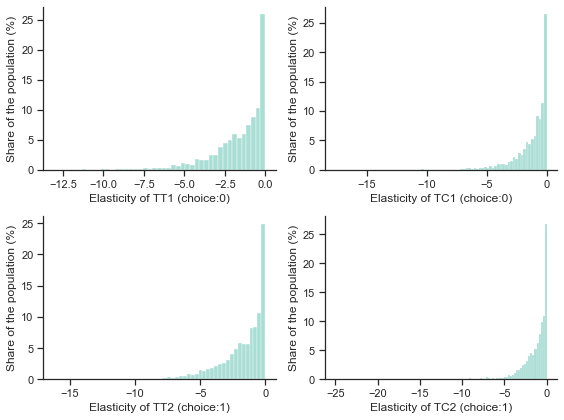

In [20]:
els_0_TT1 = model.elasticities(prob_choice=0, wrt="TT1", database=db)
els_0_TC1 = model.elasticities(prob_choice=0, wrt="TC1", database=db)
els_1_TT2 = model.elasticities(prob_choice=1, wrt="TT2", database=db)
els_1_TC1 = model.elasticities(prob_choice=1, wrt="TC2", database=db)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), squeeze=False)
e1 = sns.histplot(els_0_TT1, ax=axs[0, 0], stat="percent")
e2 = sns.histplot(els_0_TC1, ax=axs[0, 1], stat="percent")
e3 = sns.histplot(els_1_TT2, ax=axs[1, 0], stat="percent")
e4 = sns.histplot(els_1_TC1, ax=axs[1, 1], stat="percent")
e1.set(xlabel="Elasticity of TT1 (choice:0)", ylabel="Share of the population (%)")
e2.set(xlabel="Elasticity of TC1 (choice:0)", ylabel="Share of the population (%)")
e3.set(xlabel="Elasticity of TT2 (choice:1)", ylabel="Share of the population (%)")
e4.set(xlabel="Elasticity of TC2 (choice:1)", ylabel="Share of the population (%)")
sns.despine()
plt.tight_layout()
plt.show()